# Stocks news ingestion

Two options to run stocks demo (with kfpipeline and without).
1. run notebooks `01_ingest_news.ipynb`, `02_ingest_stocks.ipynb`, `03_model_training.ipynb`, `04_model_serving.ipynb`, `06_grafana_view`
2. or `01_ingest_news.ipynb`, `02_ingest_stocks.ipynb`, `05_stocks_pipeline`

> <b> Steps </b>
> * [project creation and prerequisites](#project-creation-and-prerequisites)
> * [Deploying sentiment analysis serving function from the function marketplace](#Deploying-sentiment-analysis-serving-function-from-the-function-marketplace)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## project creation and prerequisites

In [1]:
# install packages prerequisites and restart notebook
%pip install yfinance yahoo_fin transformers==4.11.3 tensorflow~=2.9.0

package yfinance installed
package yahoo_fin installed


In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2023-02-09 10:28:54,392 [info] loaded project stocks from src/ and saved in MLRun DB


In [3]:
# saving number of stocks as project parameter
project.params['NUMBER_OF_STOCKS'] = 0
project.params['STOCKS_LIST'] = 'META,AMZN,GOOGL,MSFT,NFLX'
project.save()
number_of_stocks = project.params['NUMBER_OF_STOCKS']
stocks_list = project.params['STOCKS_LIST']

## Creating a feature set and declaring the graph

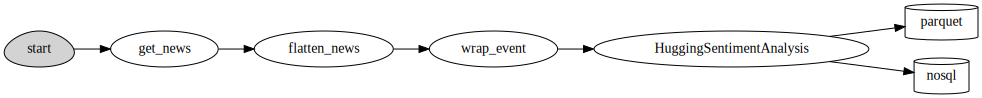

In [4]:
import mlrun.feature_store as fstore
from mlrun.datastore.targets import ParquetTarget

# creating feature set
news_set = fstore.FeatureSet("news",
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# setting up the graph
news_set.graph \
    .to(name='get_news', handler='get_news') \
    .to("storey.steps.Flatten", name="flatten_news") \
    .to(name='wrap_event', handler='wrap_event') \
    .to("HuggingSentimentAnalysis",handler= "get_sentiment", full_event=True)

news_set.set_targets([ParquetTarget(flush_after_seconds=5)], with_defaults=False)
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [5]:
# ingesting dummy (A MUST) 
import datetime
# because were ingesting locally, code must be present !
from src.news import *

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# ingesting dummy (A MUST)
name = 'stocks-dummy'

news_set.ingest(pd.DataFrame.from_dict({'ticker':[name],
                                        'Datetime': now,
                                        'n_stocks':number_of_stocks,
                                        'stocks_list':stocks_list}),
              overwrite=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


,Datetime,published,summary,title,sentiment
ticker,,,,,
A,2023-02-08 23:15:11,2023-02-08 23:15:11,Agilent Technologies A closed at 15442 in the ...,Agilent Technologies A Stock Moves 006 What Yo...,0
A,2023-02-08 14:18:02,2023-02-08 14:18:02,PayPals PYPL fourthquarter results are expecte...,PayPal PYPL Q4 Earnings to Benefit From Portfo...,1
A,2023-02-08 13:32:01,2023-02-08 13:32:01,Jack Henrys JKHY secondquarter fiscal 2023 res...,Jack Henry JKHY Q2 Earnings Miss Estimates Rev...,1
A,2023-02-07 16:54:04,2023-02-07 16:54:04,Carriers CARR fourthquarter results reflect we...,Carriers CARR Q4 Earnings InLine Revenues Beat...,1
A,2023-02-03 16:54:04,2023-02-03 16:54:04,Amazons AMZN fourthquarter results reflect str...,Amazons AMZN Q4 Earnings Fall YY Sales Beat Es...,0
A,2023-02-03 16:39:04,2023-02-03 16:39:04,MACOMs MTSI firstquarter fiscal 2023 results b...,MACOM MTSI Q1 Earnings Revenues Top Estimates...,1
A,2023-02-03 14:57:02,2023-02-03 14:57:02,Alphabets GOOGL fourthquarter results reflect ...,Alphabet GOOGL Q4 Earnings Miss Estimates Reve...,1
A,2023-02-02 23:15:11,2023-02-02 23:15:11,Agilent Technologies A closed at 15550 in the ...,Agilent Technologies A Gains But Lags Market W...,0
A,2023-02-02 17:40:05,2023-02-02 17:40:05,AMETEKs AME fourthquarter results reflect stre...,AMETEK AME Q4 Earnings Sales Surpass Estimate...,1


In [6]:
# Deploying ingestion service
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news'
                                  ,kind='serving'
                                  ,image='mlrun/mlrun'
                                  , requirements=['yahoo_fin','graphviz','transformers','tensorflow~=2.9.0']
                                  , filename='src/news.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False)

# Deploying
news_set_endpoint, function = fstore.deploy_ingestion_service_v2(featureset=news_set, run_config=run_config)

> 2023-02-09 10:30:48,264 [info] Starting remote function deploy
2023-02-09 10:30:48  (info) Deploying function
2023-02-09 10:30:48  (info) Building
2023-02-09 10:30:48  (info) Staging files and preparing base images
2023-02-09 10:30:48  (info) Building processor image
2023-02-09 10:37:14  (info) Build complete
2023-02-09 10:38:27  (info) Function deploy complete
> 2023-02-09 10:38:28,633 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-avia-get-news.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-avia-get-news-stocks-avia.default-tenant.app.vmdev94.lab.iguazeng.com/']}


## Testing ingestion service

In [7]:
import requests

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':number_of_stocks,
                                                 'stocks_list':stocks_list})
t.text

'{"id": "e4dc5efd-3588-4fbf-8380-03169e7972d7"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [8]:
import datetime

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
body = {'ticker':['news'],
        'Datetime': now,
        'n_stocks':number_of_stocks,
        'stocks_list':stocks_list}

# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint, 'body': body}, schedule='0 */1 * * *')

> 2023-02-09 10:38:28,845 [info] starting run ingestion-service-news-ingestion_service_invoker uid=f45dba3eee0e4a51be605d3cca819ef6 DB=http://mlrun-api:8080
> 2023-02-09 10:38:29,129 [info] task scheduled, {'schedule': '0 */1 * * *', 'project': 'stocks-avia', 'name': 'ingestion-service-news-ingestion_service_invoker'}
